In [2]:
# This is a simple analysis using the VAR method to regress Alberta electricity demand

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import TimeSeriesSplit

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Append data from both sheets into one dataframe
filepath = 'msa_merged_data.csv'
df = pd.read_csv(filepath, parse_dates=True,index_col='BEGIN_DATE_GMT')


#check for missing values, if there are backfill missing values
if df.isna().any().any() :  
  df = df.fillna(method='backfill')

#drop the in-built index column 
df = df.drop(df.columns[0], axis=1)

#uncomment to save backfilled dataframe
#df.to_csv("msa_merged_data_backfilled.csv")

df.index = pd.DatetimeIndex(df.index).to_period('H')

df.tail()


,HE,POOL_PRICE,AIL_DEMAND,Avg_temp,Weighted_Avg_Temp,future 1,future 2,future 3,future 4,WTI spot,dayofweek,month,year,holiday,workingday
BEGIN_DATE_GMT,,,,,,,,,,,,,,,
2020-12-30 19:00:00,13,35.10,10590.0,-3.225,-1.768968,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1
2020-12-30 20:00:00,14,34.04,10519.0,-2.650,-1.299453,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1
2020-12-30 21:00:00,15,34.77,10535.0,-2.050,-0.006591,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1
2020-12-30 22:00:00,16,35.61,10598.0,-2.350,-0.833002,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1
2020-12-30 23:00:00,17,37.92,10872.0,-2.800,-1.124149,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1


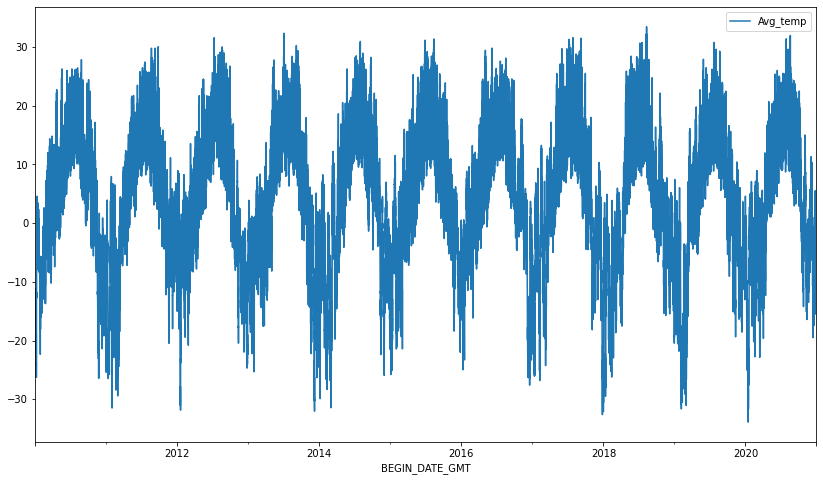

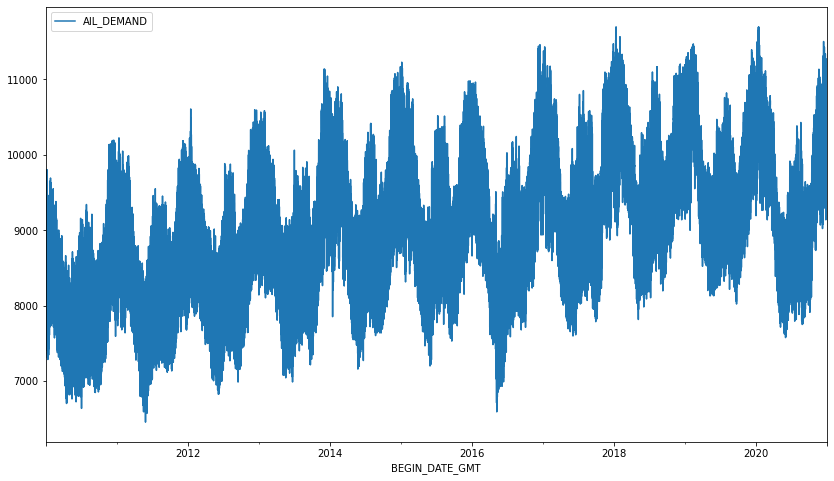

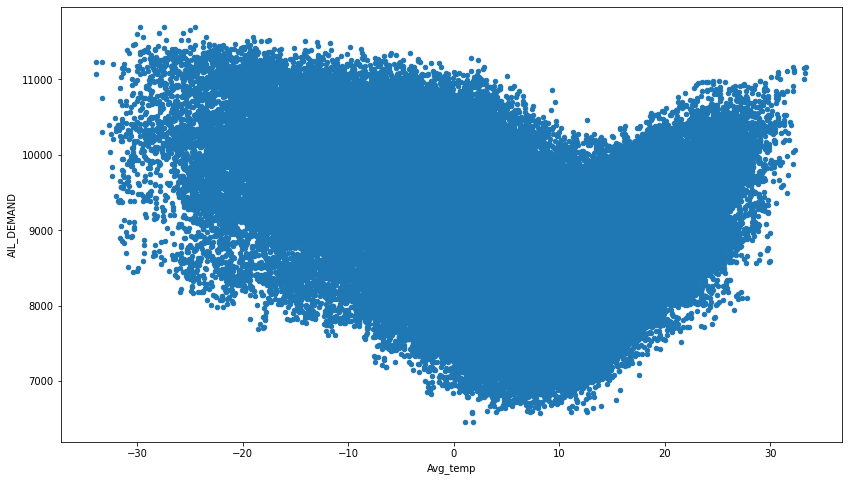

In [7]:
# Initial Plots

df.reset_index().plot(figsize= (14,8),x='BEGIN_DATE_GMT', y='Avg_temp')
df.reset_index().plot(figsize= (14,8),x='BEGIN_DATE_GMT', y='AIL_DEMAND')
df.reset_index().plot(figsize= (14,8),x='Avg_temp', y='AIL_DEMAND',kind='scatter')


In [36]:
# Split data into train (80%) and test (20%) partitions
df_train, df_test = np.split(df, [int(.8 *len(df))])

print(df_train.shape) 
print(df_test.shape)

df_test.tail()

(77112, 15)
(19278, 15)


,HE,POOL_PRICE,AIL_DEMAND,Avg_temp,Weighted_Avg_Temp,future 1,future 2,future 3,future 4,WTI spot,dayofweek,month,year,holiday,workingday
BEGIN_DATE_GMT,,,,,,,,,,,,,,,
2020-12-30 19:00,13,35.10,10590.0,-3.225,-1.768968,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1
2020-12-30 20:00,14,34.04,10519.0,-2.650,-1.299453,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1
2020-12-30 21:00,15,34.77,10535.0,-2.050,-0.006591,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1
2020-12-30 22:00,16,35.61,10598.0,-2.350,-0.833002,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1
2020-12-30 23:00,17,37.92,10872.0,-2.800,-1.124149,48.4,48.5,48.57,48.59,48.24,2,12,2020,0,1


In [ ]:
# Perform Augment Dicky Fuller test as a thorough test for stationarity
# adapted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
def adfuller_test(series, name='', signif=0.05,  verbose=False):
    
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        
df_no_dates = df_train.drop(columns=['HE','workingday','dayofweek','holiday','year','month'])       
    
for name, column in df_no_dates.items():
    adfuller_test(column, name=column.name)
    print('\n')
        
        
# For now all series are stationary so no need for any transformations 

In [ ]:
 # Perform Johanson's Cointegration Test to check for a statistically significant relationship between variables
# adapted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/ 
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Significant  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_no_dates)

# Result : 

In [47]:
model = VAR(df_train)
x = model.select_order(maxlags=60) #find optimal lag order
x.summary()

,AIC,BIC,FPE,HQIC
0,26.10,26.11,2.174e+11,26.11
1,-43.72,-43.69,1.027e-19,-43.71
2,-45.20,-45.15,2.333e-20,-45.19
3,-45.39,-45.31,1.931e-20,-45.37
4,-45.53,-45.42,1.690e-20,-45.49
5,-45.65,-45.52,1.491e-20,-45.61
6,-45.79,-45.63,1.296e-20,-45.74
7,-45.91,-45.72,1.148e-20,-45.85
8,-46.01,-45.79,1.048e-20,-45.94
9,-46.07,-45.82,9.855e-21,-45.99


In [48]:
#According to AIC, the optimal lag order is 51 
model_fitted = model.fit(51)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, Mar, 2021
Time:                     17:24:41
--------------------------------------------------------------------
No. of Equations:         15.0000    BIC:                   -54.9534
Nobs:                     77061.0    HQIC:                  -55.9093
Log likelihood:           541853.    FPE:                3.42713e-25
AIC:                     -56.3329    Det(Omega_mle):     2.95458e-25
--------------------------------------------------------------------
Results for equation HE
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        28.402945         1.930733           14.711           0.000
L1.HE                        -0.089795         0.003620          -24.803           0.000
L1.POOL_PRICE                -0

In [49]:
# Forecast
# Get the lag order
lag_order = model_fitted.k_ar

# forecast based on the last <lag_order> inputs
forecast_input = df_train.values[-lag_order:]

nobs = len(df_test)
#  inform the model to predict the next 19278 values (i.e. the same number of values in test partition)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)

# organize the output into dataFrame layout, add ‘_forecast’ suffix at each column indicating they are the forecasted values
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + "_forecast")  

In [50]:
# Calulate accuracy
forecast = df_forecast['AIL_DEMAND_forecast'].values
actual = df_test['AIL_DEMAND']

mae = np.mean(np.abs(forecast - actual))  #Mean Absolute error
mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) #Mean absolute percentage error

print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)


Mean Absolute Error: 605.0437702012687
Mean Absolute Percentage Error: 0.06523180460931853


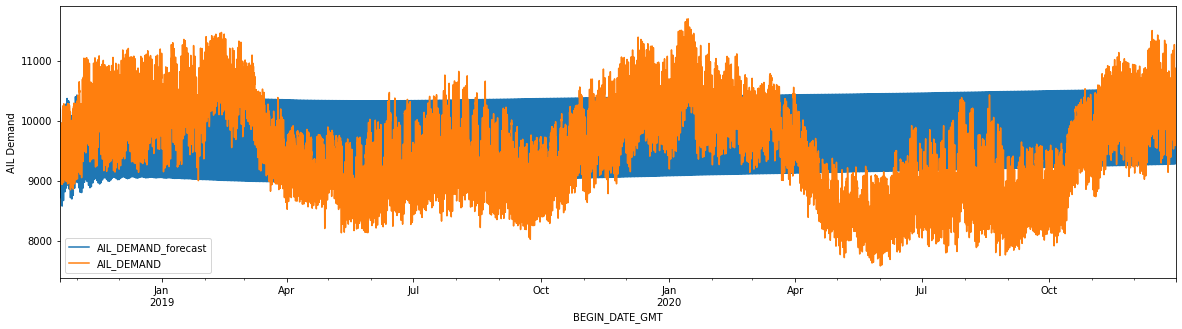

In [56]:
# Plot forecast against actual data
ax = df_forecast.reset_index().plot(figsize =(20,5) ,x='BEGIN_DATE_GMT', y='AIL_DEMAND_forecast')
ax.set_xlabel("Date")
ax.set_ylabel("AIL Demand")
df_test.plot(ax=ax, y='AIL_DEMAND')
